In [62]:
import pandas as pd 
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')  #for nicw white background
%matplotlib inline
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as pdr
from datetime import datetime

In [63]:
tech_list = ['AAPL','GOOG','MSFT','AMZN']
end = datetime.now()
start = datetime(end.year-1,end.month,end.day)

In [64]:
for stock in tech_list:
    globals()[stock] = pdr.get_data_yahoo(stock,start,end)

In [65]:
AAPL.describe()

,High,Low,Open,Close,Volume,Adj Close
count,251.000000,251.000000,251.000000,251.000000,2.510000e+02,251.000000
mean,189.561753,185.823705,187.686694,187.711953,3.270475e+07,186.174273
std,22.281577,22.008797,22.145621,22.160721,1.417972e+07,21.904664
min,145.720001,142.000000,143.979996,142.190002,1.251390e+07,141.582779
25%,173.035004,169.724998,171.320000,171.004997,2.288735e+07,170.214981
50%,187.399994,184.940002,186.289993,186.119995,2.918400e+07,184.351776
75%,209.375000,205.784996,207.320000,207.760002,3.919905e+07,205.900421
max,233.470001,229.779999,230.779999,232.070007,9.624670e+07,230.275482


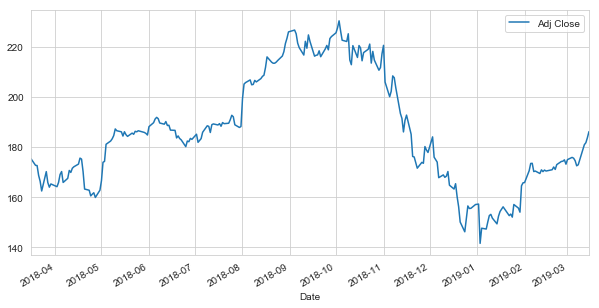

In [66]:
# Historical view of the closing price
AAPL['Adj Close'].plot(legend=True,figsize=(10,5))

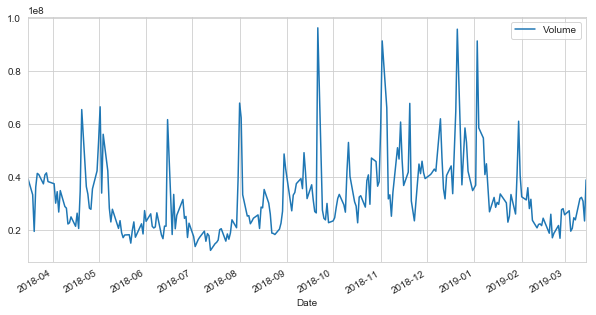

In [67]:
AAPL['Volume'].plot(legend=True,figsize=(10,5))

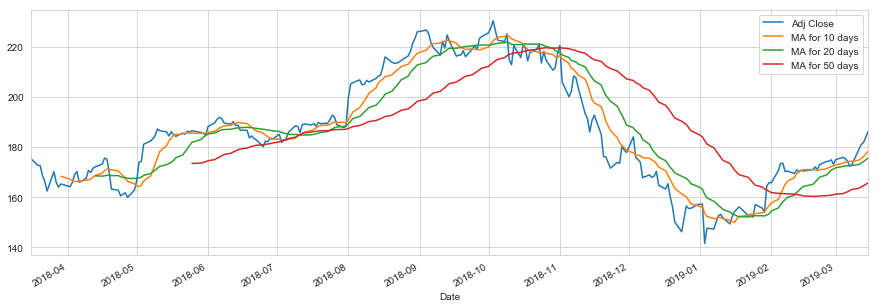

In [68]:
ma_day=[10,20,50]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    AAPL[column_name]=AAPL['Adj Close'].rolling(ma).mean()

AAPL[['Adj Close','MA for 10 days','MA for 20 days','MA for 50 days']].plot(figsize=(15,5))

Section 2 - Daily Return Analysis

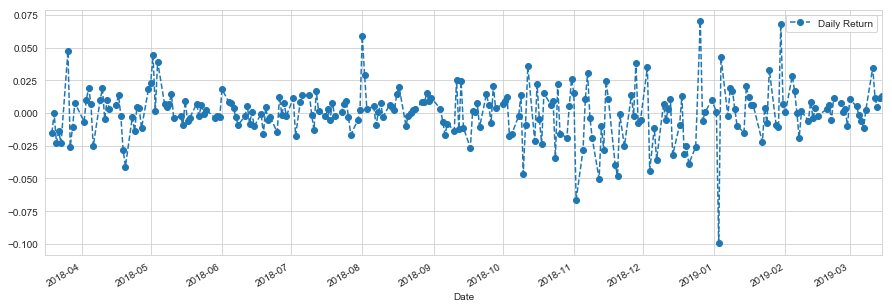

In [69]:
# Retrieving the daily returns for the Apple stock.
AAPL['Daily Return'] = AAPL['Adj Close'].pct_change()
AAPL['Daily Return'].plot(figsize=(15,5),legend=True,linestyle='--',marker='o')

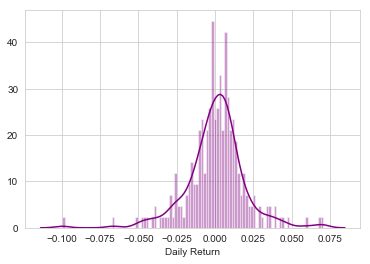

In [70]:
#Average daily return on histogram. 
sns.distplot(AAPL['Daily Return'].dropna(),bins =100,color='purple')

In [71]:
closing_df=pdr.get_data_yahoo(tech_list,start,end)['Adj Close']

closing_df.head()

Symbols,AAPL,AMZN,GOOG,MSFT
Date,,,,
2018-03-16,175.349915,1571.680054,1135.729980,93.029739
2018-03-19,172.670731,1544.930054,1099.819946,91.348114
2018-03-20,172.611618,1586.510010,1097.709961,91.584137
2018-03-21,168.701157,1581.859985,1090.880005,90.944923
2018-03-22,166.317459,1544.920044,1049.079956,88.299576


In [72]:
# Daily returns for all the stocks
tech_rets= closing_df.pct_change()

tech_rets.head()

Symbols,AAPL,AMZN,GOOG,MSFT
Date,,,,
2018-03-16,NaN,NaN,NaN,NaN
2018-03-19,-0.015279,-0.017020,-0.031618,-0.018076
2018-03-20,-0.000342,0.026914,-0.001918,0.002584
2018-03-21,-0.022655,-0.002931,-0.006222,-0.006980
2018-03-22,-0.014130,-0.023352,-0.038318,-0.029087




Comparing the daily percentage return of two stocks to check how they correlated.


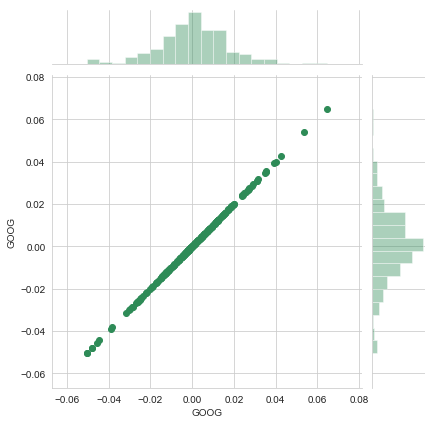

In [73]:
sns.jointplot('GOOG','GOOG',tech_rets,kind='scatter',color='seagreen')

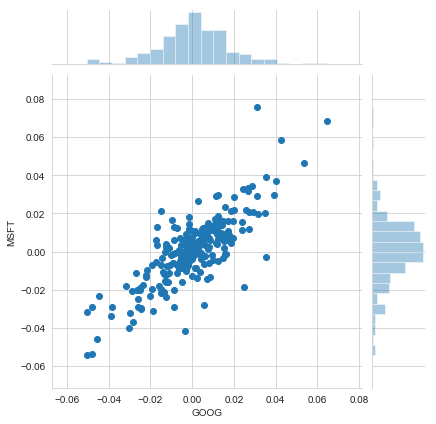

In [74]:
sns.jointplot('GOOG','MSFT',tech_rets,kind='scatter')

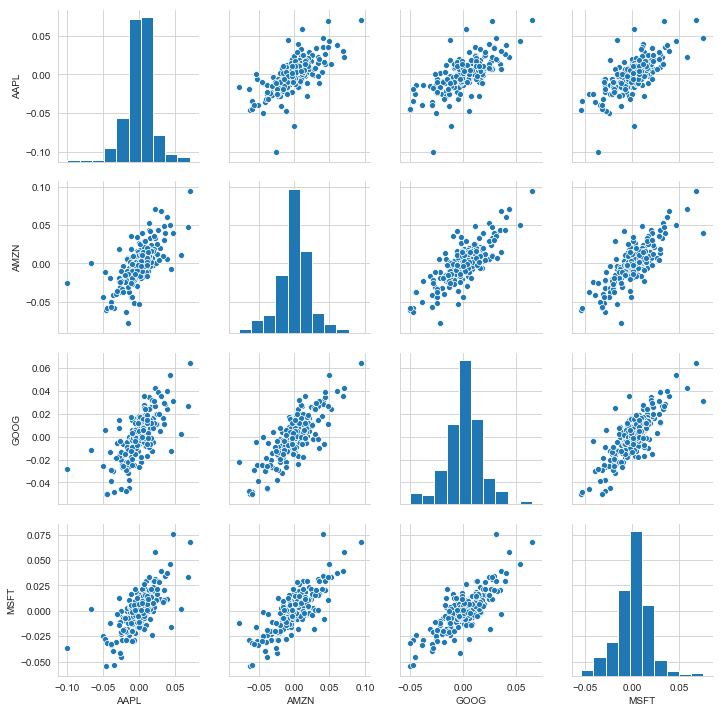

In [75]:
sns.pairplot(tech_rets.dropna())

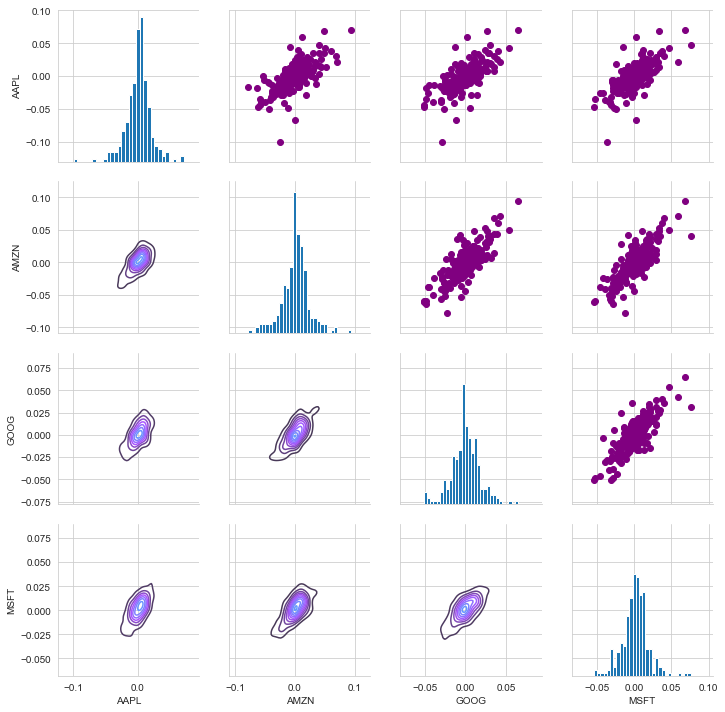

In [76]:
returns_fig = sns.PairGrid(tech_rets.dropna())

returns_fig.map_upper(plt.scatter,color='purple')

returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

returns_fig.map_diag(plt.hist,bins=30)

Getting actual numerical values for the correlation between the stocks' daily return values. 

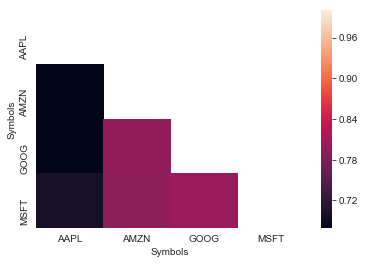

In [77]:
corr=tech_rets.corr()
mask=np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr,annot=None,mask=mask)


Risk Analysis


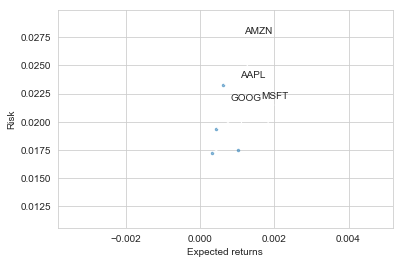

In [78]:
rets = tech_rets.dropna()

area=np.pi*2

plt.scatter(rets.mean(),rets.std(),alpha=0.5,s=area)

plt.xlabel('Expected returns')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (50, 50),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=-0.3'))


Value at Risk


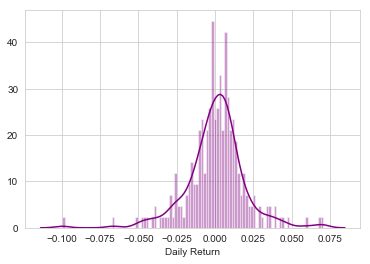

In [79]:
sns.distplot(AAPL['Daily Return'].dropna(),bins=100,color='purple')

In [80]:
rets.head()

Symbols,AAPL,AMZN,GOOG,MSFT
Date,,,,
2018-03-19,-0.015279,-0.017020,-0.031618,-0.018076
2018-03-20,-0.000342,0.026914,-0.001918,0.002584
2018-03-21,-0.022655,-0.002931,-0.006222,-0.006980
2018-03-22,-0.014130,-0.023352,-0.038318,-0.029087
2018-03-23,-0.023157,-0.031950,-0.026223,-0.029068


In [81]:
rets['AAPL'].quantile(0.05)

-0.029930148516846986

Value at Risk using the Monte Carlo method


In [96]:

days = 365
dt = 1/days
mu = rets.mean()['GOOG']
sigma = rets.std()['GOOG']



def stock_monte_carlo(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1,days):
        
        
        shock[x] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        drift[x] = mu * dt
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

In [97]:
GOOG.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-03-16,1155.880005,1131.959961,1154.140015,1135.729980,3092000,1135.729980
2018-03-19,1121.989990,1089.010010,1120.010010,1099.819946,2805900,1099.819946
2018-03-20,1105.199951,1083.459961,1099.000000,1097.709961,1831900,1097.709961
2018-03-21,1106.300049,1085.150024,1092.739990,1090.880005,1878900,1090.880005
2018-03-22,1082.900024,1045.910034,1081.880005,1049.079956,2667000,1049.079956


Text(0.5, 1.0, 'Monte Carlo Analysis for Google')

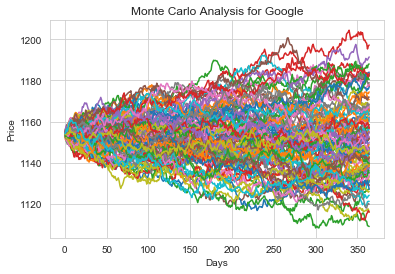

In [101]:
start_price = 1154.14

for run in range(100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))
plt.xlabel("Days")
plt.ylabel("Price")  
plt.title('Monte Carlo Analysis for Google')

In [102]:

runs=1000

simulations = np.zeros(runs)

for run in range(runs):
    
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]

Text(0.5, 1.0, 'Final price distribution for Google Stock after 365 days')

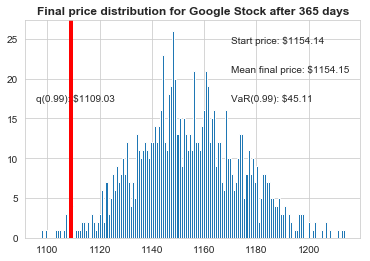

In [103]:

q = np.percentile(simulations, 1)
    
plt.hist(simulations,bins=150)
plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())
plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price - q,))
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)
plt.axvline(x=q, linewidth=4, color='r')
plt.title(u"Final price distribution for Google Stock after %s days" % days, weight='bold')